# Import Packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# AAPL Stocks

## Data Pre-processing

In [2]:
# Load the data with date parsing
aapl_df = pd.read_csv('AAPL_processed_data.csv', parse_dates=['Date'])

# Remove the first 49 rows due to NaN values in SMA columns
aapl_df = aapl_df.iloc[49:]

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))

aapl_scaled_data = scaler.fit_transform(aapl_df[['Open', 'High', 'Low', 'Close', 'Volume',
                                                 '5_day_SMA', '20_day_SMA', '50_day_SMA', '14_day_RSI',
                                                 'Lagged_Close', 'ATR', 'Day_of_Week', 'Daily_Return']]) # Selecting only the wanted input features

# Prepare the data for LSTM (Sequencing)
look_back = 60  # No. of previous time steps to use

aapl_X, aapl_y = [], []

for i in range(look_back, len(aapl_scaled_data)):
    aapl_X.append(aapl_scaled_data[i - look_back : i])  # Create sequences of past data
    aapl_y.append(aapl_scaled_data[i, 3])  # Use the 'Close' price as the output, 3 being the location of 'Close'

aapl_X, aapl_y = np.array(aapl_X), np.array(aapl_y)


# Split the data into training and test sets
split = int(0.8 * len(aapl_X)) # 80% Train 20% Validate

aapl_Xtrain, aapl_Xtest = aapl_X[:split], aapl_X[split:]
aapl_ytrain, aapl_ytest = aapl_y[:split], aapl_y[split:]

# Getting the corresponding dates for the test set
aapl_test_dates = aapl_df['Date'].iloc[look_back + split:].values

## LSTM Model

In [3]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(aapl_Xtrain.shape[1], aapl_Xtrain.shape[2])))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))  # Dense layer to produce the final prediction

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,051 (129.11 KB)

 Trainable params: 33,051 (129.11 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Fitting the model
aapl_history = model.fit(aapl_Xtrain, aapl_ytrain, epochs=50, batch_size=32, validation_data=(aapl_Xtest, aapl_ytest), verbose=1)

# Predictions
aapl_predicted_prices = model.predict(aapl_Xtest)

# Inverse transformation for predicted prices
aapl_predicted_prices_reshaped = np.zeros((aapl_predicted_prices.shape[0], aapl_scaled_data.shape[1])) # Creating 2D arrays with the same shape as aapl_scaled_data
aapl_predicted_prices_reshaped[:, 3] = aapl_predicted_prices.flatten()  # Fill only the 'Close' prices

aapl_predicted_prices_inverse = scaler.inverse_transform(aapl_predicted_prices_reshaped)[:, 3]  # Get only the 'Close' prices

# Inverse transformation for actual prices
aapl_ytest_reshaped = np.zeros((aapl_ytest.shape[0], aapl_scaled_data.shape[1]))  # Creating 2D arrays with the same shape as aapl_scaled_data
aapl_ytest_reshaped[:, 3] = aapl_ytest.flatten()  # Fill only the 'Close' prices

aapl_actual_prices_inverse = scaler.inverse_transform(aapl_ytest_reshaped)[:, 3]  # Get only the 'Close' prices

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0096 - val_loss: 0.0019
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0016 - val_loss: 0.0049
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0013 - val_loss: 0.0081
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 0.0011 - val_loss: 9.7455e-04
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0012 - val_loss: 0.0078
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 9.8138e-04 - val_loss: 0.0011
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 8.9282e-04 - val_loss: 8.2629e-04
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 9.4548e-04 - val_loss: 0.0012
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 5

## Visualisation

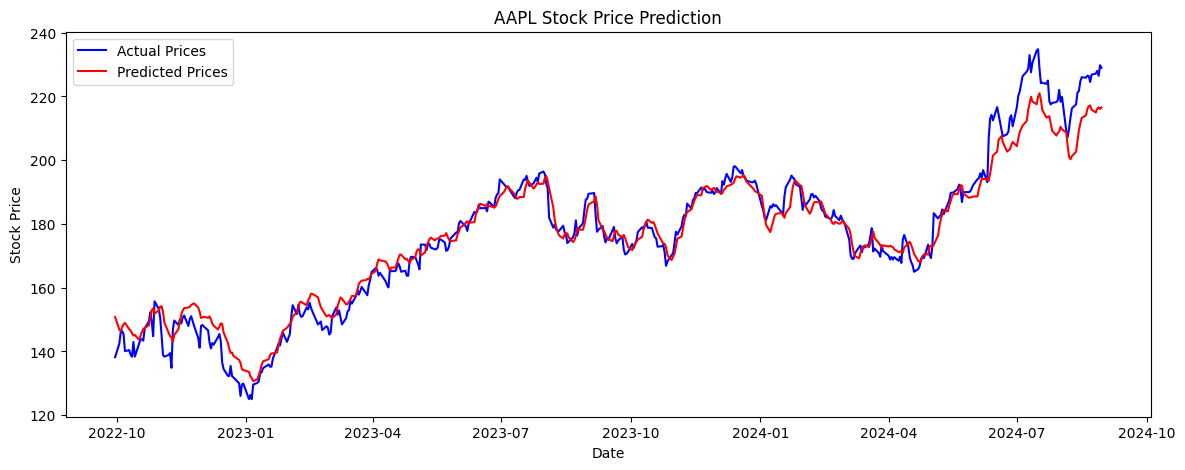

In [15]:
# Plotting the comparison of actual close prices with predicted close prices
plt.figure(figsize=(14, 5))
plt.plot(aapl_test_dates, aapl_actual_prices_inverse, color='blue', label='Actual Prices')
plt.plot(aapl_test_dates, aapl_predicted_prices_inverse, color='red', label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.legend()
plt.show()

# AMZN Stocks

## Data Pre-processing

In [6]:
# Load the data with date parsing
amzn_df = pd.read_csv('AMZN_processed_data.csv', parse_dates=['Date'])

# Remove the first 49 rows due to NaN values in SMA columns
amzn_df = amzn_df.iloc[49:]

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))

amzn_scaled_data = scaler.fit_transform(amzn_df[['Open', 'High', 'Low', 'Close', 'Volume',
                                                 '5_day_SMA', '20_day_SMA', '50_day_SMA', '14_day_RSI',
                                                 'Lagged_Close', 'ATR', 'Day_of_Week', 'Daily_Return']]) # Selecting only the wanted input features

# Prepare the data for LSTM (Sequencing)
look_back = 60  # No. of previous time steps to use

amzn_X, amzn_y = [], []

for i in range(look_back, len(amzn_scaled_data)):
    amzn_X.append(amzn_scaled_data[i - look_back : i])  # Create sequences of past data
    amzn_y.append(amzn_scaled_data[i, 3])  # Use the 'Close' price as the output, 3 being the location of 'Close'

amzn_X, amzn_y = np.array(amzn_X), np.array(amzn_y)


# Split the data into training and test sets
split = int(0.8 * len(amzn_X)) # 80% Train 20% Validate

amzn_Xtrain, amzn_Xtest = amzn_X[:split], amzn_X[split:]
amzn_ytrain, amzn_ytest = amzn_y[:split], amzn_y[split:]

# Getting the corresponding dates for the test set
amzn_test_dates = amzn_df['Date'].iloc[look_back + split:].values

## LSTM Model

In [7]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(amzn_Xtrain.shape[1], amzn_Xtrain.shape[2])))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))  # Dense layer to produce the final prediction

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,051 (129.11 KB)

 Trainable params: 33,051 (129.11 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Fitting the model
amzn_history = model.fit(amzn_Xtrain, amzn_ytrain, epochs=50, batch_size=32, validation_data=(amzn_Xtest, amzn_ytest), verbose=1)

# Predictions
amzn_predicted_prices = model.predict(amzn_Xtest)

# Inverse transformation for predicted prices
amzn_predicted_prices_reshaped = np.zeros((amzn_predicted_prices.shape[0], amzn_scaled_data.shape[1])) # Creating 2D arrays with the same shape as amzn_scaled_data
amzn_predicted_prices_reshaped[:, 3] = amzn_predicted_prices.flatten()  # Fill only the 'Close' prices

amzn_predicted_prices_inverse = scaler.inverse_transform(amzn_predicted_prices_reshaped)[:, 3]  # Get only the 'Close' prices

# Inverse transformation for actual prices
amzn_ytest_reshaped = np.zeros((amzn_ytest.shape[0], amzn_scaled_data.shape[1]))  # Creating 2D arrays with the same shape as amzn_scaled_data
amzn_ytest_reshaped[:, 3] = amzn_ytest.flatten()  # Fill only the 'Close' prices

amzn_actual_prices_inverse = scaler.inverse_transform(amzn_ytest_reshaped)[:, 3]  # Get only the 'Close' prices

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.0429 - val_loss: 0.0027
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0024 - val_loss: 9.8530e-04
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0025 - val_loss: 9.0420e-04
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0022 - val_loss: 8.2366e-04
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step

## Visualisation

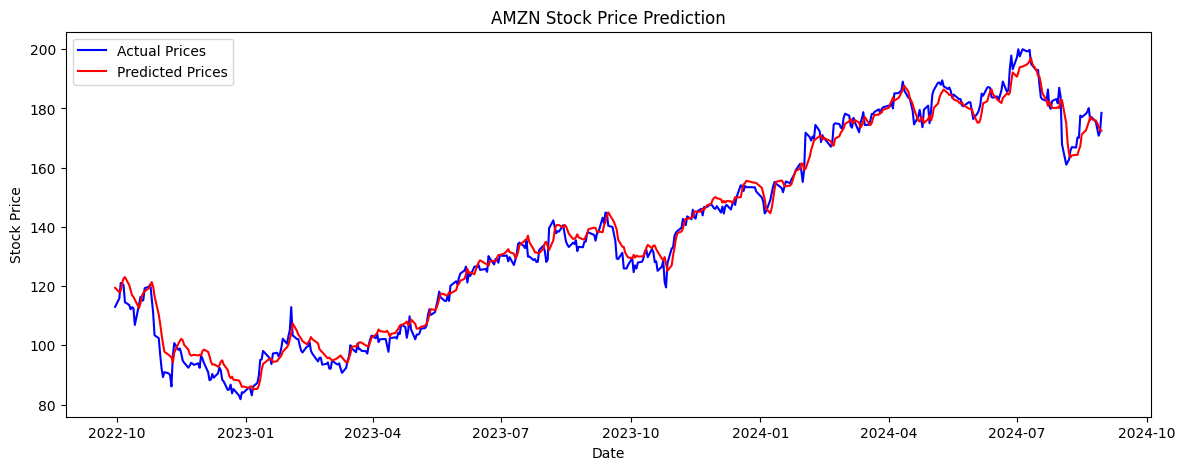

In [14]:
# Plotting the comparison of actual close prices with predicted close prices
plt.figure(figsize=(14, 5))
plt.plot(amzn_test_dates, amzn_actual_prices_inverse, color='blue', label='Actual Prices')
plt.plot(amzn_test_dates, amzn_predicted_prices_inverse, color='red', label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('AMZN Stock Price Prediction')
plt.legend()
plt.show()

# GOOG Stocks

## Data Pre-processing

In [10]:
# Load the data with date parsing
goog_df = pd.read_csv('GOOG_processed_data.csv', parse_dates=['Date'])

# Remove the first 49 rows due to NaN values in SMA columns
goog_df = goog_df.iloc[49:]

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))

goog_scaled_data = scaler.fit_transform(goog_df[['Open', 'High', 'Low', 'Close', 'Volume',
                                                 '5_day_SMA', '20_day_SMA', '50_day_SMA', '14_day_RSI',
                                                 'Lagged_Close', 'ATR', 'Day_of_Week', 'Daily_Return']]) # Selecting only the wanted input features

# Prepare the data for LSTM (Sequencing)
look_back = 60  # No. of previous time steps to use

goog_X, goog_y = [], []

for i in range(look_back, len(goog_scaled_data)):
    goog_X.append(goog_scaled_data[i - look_back : i])  # Create sequences of past data
    goog_y.append(goog_scaled_data[i, 3])  # Use the 'Close' price as the output, 3 being the location of 'Close'

goog_X, goog_y = np.array(goog_X), np.array(goog_y)


# Split the data into training and test sets
split = int(0.8 * len(goog_X)) # 80% Train 20% Validate

goog_Xtrain, goog_Xtest = goog_X[:split], goog_X[split:]
goog_ytrain, goog_ytest = goog_y[:split], goog_y[split:]

# Getting the corresponding dates for the test set
goog_test_dates = goog_df['Date'].iloc[look_back + split:].values

## LSTM Model

In [11]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(goog_Xtrain.shape[1], goog_Xtrain.shape[2])))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))  # Dense layer to produce the final prediction

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 60, 50)              │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,051 (129.11 KB)

 Trainable params: 33,051 (129.11 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Fitting the model
goog_history = model.fit(goog_Xtrain, goog_ytrain, epochs=50, batch_size=32, validation_data=(goog_Xtest, goog_ytest), verbose=1)

# Predictions
goog_predicted_prices = model.predict(goog_Xtest)

# Inverse transformation for predicted prices
goog_predicted_prices_reshaped = np.zeros((goog_predicted_prices.shape[0], goog_scaled_data.shape[1])) # Creating 2D arrays with the same shape as goog_scaled_data
goog_predicted_prices_reshaped[:, 3] = goog_predicted_prices.flatten()  # Fill only the 'Close' prices

goog_predicted_prices_inverse = scaler.inverse_transform(goog_predicted_prices_reshaped)[:, 3]  # Get only the 'Close' prices

# Inverse transformation for actual prices
goog_ytest_reshaped = np.zeros((goog_ytest.shape[0], goog_scaled_data.shape[1]))  # Creating 2D arrays with the same shape as goog_scaled_data
goog_ytest_reshaped[:, 3] = goog_ytest.flatten()  # Fill only the 'Close' prices

goog_actual_prices_inverse = scaler.inverse_transform(goog_ytest_reshaped)[:, 3]  # Get only the 'Close' prices

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0635 - val_loss: 0.0066
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0026 - val_loss: 0.0045
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0019 - val_loss: 0.0047
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 9.7

## Visualisation

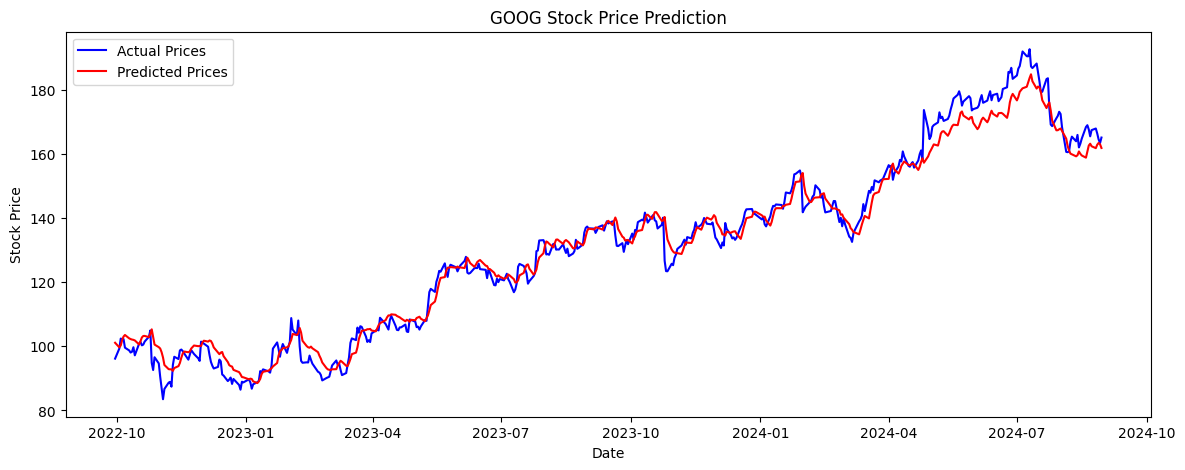

In [13]:
# Plotting the comparison of actual close prices with predicted close prices
plt.figure(figsize=(14, 5))
plt.plot(goog_test_dates, goog_actual_prices_inverse, color='blue', label='Actual Prices')
plt.plot(goog_test_dates, goog_predicted_prices_inverse, color='red', label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('GOOG Stock Price Prediction')
plt.legend()
plt.show()